In [1]:
import sys, os, itertools
import re, nltk
from nltk import pos_tag
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import sklearn, gensim
from sklearn.decomposition import PCA
from gensim.corpora import Dictionary
sys.path.append(os.path.expanduser("~")+'/Desktop/topic_modeling/fine_grained_topic_modeling_for_misinformation/src/')
sys.path.append(os.path.expanduser("~")+'/Desktop/topic_modeling/fine_grained_topic_modeling_for_misinformation/src/')
os.chdir(os.path.expanduser("~")+'/Desktop/topic_modeling/fine_grained_topic_modeling_for_misinformation/data/')
from utils import preprocess_for_bow
from models.lda import LDAwrappers
from models.hdp import HDPwrapper
from models.gsdmm import MovieGroupProcessWrapper
from models.lftm import LFTMwrapper
from models.bertopic import BERTopicWrapper
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster import hierarchy as sch
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import norm
from numpy import random
from bertopic.representation import MaximalMarginalRelevance, KeyBERTInspired
keybert = KeyBERTInspired()
mmr = MaximalMarginalRelevance(diversity=0.3)
chained_representation = [keybert, mmr]

In [94]:
setopics=["Virus Origin and bioweapon theory", "Virus contraction (who contracts the virus) and transmission (what transmits the virus)", 
                    "Incidence, Mortality and 'Casedemic'", "Prevention (Face Mask, Vitamin D, etc.)", 
                    "Treatment (Ivermectim, chloroquine and hydroxychloroquine, etc)", "Vaccines", "COVID-19 Denialism"]

# dataset 1

In [3]:
data1 = preprocess_for_bow('data.csv', preprocessing=False)
bertopic=BERTopicWrapper(data1['text'], data1['ids'], representation_model=chained_representation)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [7]:
bertopic.set_topics(setopics, top_n=50, min_sim=0.45)

In [8]:
bertopic.sbert_cluster_set_topics()

## Results from label inputs

In [9]:
print('this print displays the count of docs associated with the topic labels set')
print('')
for i in range(len(setopics)):
    print('topic:', bertopic.topics_set_embeddings[i]['topic_title'], 'yields ', len(bertopic.topics_set_embeddings[i]['topic_idxs']),
            'distributed over', len(bertopic.topics_set_embeddings[i]['topic_labels']),'original bertopics')

this print displays the count of docs associated with the topic labels set

topic: Virus Origin and bioweapon theory yields  187 distributed over 5 original bertopics
topic: Virus contraction (who contracts the virus) and transmission (what transmits the virus) yields  20 distributed over 2 original bertopics
topic: Incidence, Mortality and 'Casedemic' yields  402 distributed over 14 original bertopics
topic: Prevention (Face Mask, Vitamin D, etc.) yields  540 distributed over 2 original bertopics
topic: Treatment (Ivermectim, chloroquine and hydroxychloroquine, etc) yields  79 distributed over 2 original bertopics
topic: Vaccines yields  895 distributed over 38 original bertopics
topic: COVID-19 Denialism yields  13817 distributed over 50 original bertopics


### reclustering corpus on centroids extracted from docs above (SBERT)

In [10]:
np.unique(bertopic.sbert_clusters, return_counts=True)
for i in range(len(setopics)):
    print(bertopic.topics_set_embeddings[i]['topic_title'],'->',np.unique(bertopic.sbert_clusters, return_counts=True)[1][i])

Virus Origin and bioweapon theory -> 7610
Virus contraction (who contracts the virus) and transmission (what transmits the virus) -> 1412
Incidence, Mortality and 'Casedemic' -> 1617
Prevention (Face Mask, Vitamin D, etc.) -> 655
Treatment (Ivermectim, chloroquine and hydroxychloroquine, etc) -> 1978
Vaccines -> 1769
COVID-19 Denialism -> 15150


In [39]:
print('examples clusteres')
np.unique(bertopic.sbert_clusters, return_counts=True)
for i in range(len(setopics)):
    print(bertopic.topics_set_embeddings[i]['topic_title'],'->',data1['text'][bertopic.topics_set_embeddings[i]['topic_idxs'][5]])

examples clusteres
Virus Origin and bioweapon theory -> No lab is capable of engineering it. It would be idiotic to use the Coronavirus for a bioweapon. They'd use a far more deadly pathogen. Coronavirus readily trades genetic material. We've already had 2 zoonotic diseases from the species SARS & MERS. Not man made.
Virus contraction (who contracts the virus) and transmission (what transmits the virus) -> Covid-19 does not exist as a virus, but rather a bacterium that has been exposed to 5G radiation.
Incidence, Mortality and 'Casedemic' -> Fascinating concept. You’re referencing the fact that they aren’t testing the dead only the living? Instead relying on expert opinion. Where did a plane crash death get attributed to covid19? Or a cancer patient dying of cancer get reclassified as a covid19 death?
Prevention (Face Mask, Vitamin D, etc.) -> Vitamin D treatment for COVID-19 patients can reduce deaths by up to 60%.
Treatment (Ivermectim, chloroquine and hydroxychloroquine, etc) -> Hyd

## using examples instead of labels

In [42]:
topic_examples=["Harvard epidemiologist says he is not saying the Corona virus was bioengineered as a bioweapon but a new study says it does have a center segment in its genome encoding a special protein to get it into human cells and it did not get there through natural random mechanisms", 
                "Viruses are dead material expelled from healing cells. Everyone has thousands of viruses inside their body. Viruses do not kill humans, unhealthy immune systems do",
                    "This isn’t new information-6% of the deaths were in people that had no other issues. We know that COVID preys on people with comorbidies-which unfortunately there are a lot of in the US. But that information doesn’t help with your arguement...I realize. But the data makes sense", 
                    "This is a very important study on vitamin D and Covid-19. Its findings are incredibly clear. An 80% reduction in need for ICU and a 60% reduction in deaths, simply by giving a very cheap and very safe therapy - calcifediol, or activated vitamin D.", 
                    "Hydroxychloroquine is not an antiviral it is an antimalarial drug Science isn't 'silly or ideological' it is based on hypothesis testing - the hypothesis that HQ was an effective treatment for #Covid19 was tested and it was found to have no effect As I say sorry to disappoint", 
                    "Worth another listen. 700 babies and children will be injected with the experimental MODERNA vaccine in about 45 days in Rochester, NY. How is this even REMOTELY ethical? How can a BABY ‘consent’ to being a lab rat? @DrMikeMendoza @CountyExecBello", 
                    "HOW.MANY AMERICANS BELIEVE THIS COVID HOAX ?? I DO! I BELIEVE R MILITARY R COPS ICE AGENTS NATIONAL GUARD SHOULD DO WHATS RIGHT ONLY TAKE ORDERS FROM TRUMP (NEVER THESE DEMOCRATE GOVS& MAYORS WHO WERE ELECTED BY FAKE BALLOTS PAID 4 BY SOROS)"]

In [50]:
bertopic.set_topics(topic_examples, top_n=50, min_sim=0.55)
bertopic.sbert_cluster_set_topics()

In [51]:
print('this print displays the count of docs associated with the topic labels set')
print('')
for i in range(len(setopics)):
    print('topic:', i, 'yields ', len(bertopic.topics_set_embeddings[i]['topic_idxs']),
            'distributed over', len(bertopic.topics_set_embeddings[i]['topic_labels']),'original bertopics')

this print displays the count of docs associated with the topic labels set

topic: 0 yields  119 distributed over 5 original bertopics
topic: 1 yields  36 distributed over 3 original bertopics
topic: 2 yields  519 distributed over 18 original bertopics
topic: 3 yields  47 distributed over 2 original bertopics
topic: 4 yields  77 distributed over 3 original bertopics
topic: 5 yields  255 distributed over 11 original bertopics
topic: 6 yields  148 distributed over 8 original bertopics


In [56]:
print('examples clusteres')
np.unique(bertopic.sbert_clusters, return_counts=True)
for i in range(len(setopics)):
    print(setopics[i],'->',data1['text'][bertopic.topics_set_embeddings[i]['topic_idxs'][5]])

examples clusteres
Virus Origin and bioweapon theory -> No lab is capable of engineering it. It would be idiotic to use the Coronavirus for a bioweapon. They'd use a far more deadly pathogen. Coronavirus readily trades genetic material. We've already had 2 zoonotic diseases from the species SARS & MERS. Not man made.
Virus contraction (who contracts the virus) and transmission (what transmits the virus) -> Covid-19 does not exist as a virus, but rather a bacterium that has been exposed to 5G radiation.
Incidence, Mortality and 'Casedemic' -> Fascinating concept. You’re referencing the fact that they aren’t testing the dead only the living? Instead relying on expert opinion. Where did a plane crash death get attributed to covid19? Or a cancer patient dying of cancer get reclassified as a covid19 death?
Prevention (Face Mask, Vitamin D, etc.) -> Vitamin D treatment for COVID-19 patients can reduce deaths by up to 60%.
Treatment (Ivermectim, chloroquine and hydroxychloroquine, etc) -> Hyd

In [73]:
print('reclustering')
np.unique(bertopic.sbert_clusters, return_counts=True)
for i in range(len(setopics)):
    print(setopics[i],'->',np.unique(bertopic.sbert_clusters, return_counts=True)[1][i])

reclustering
Virus Origin and bioweapon theory -> 2319
Virus contraction (who contracts the virus) and transmission (what transmits the virus) -> 7946
Incidence, Mortality and 'Casedemic' -> 2206
Prevention (Face Mask, Vitamin D, etc.) -> 1561
Treatment (Ivermectim, chloroquine and hydroxychloroquine, etc) -> 509
Vaccines -> 1658
COVID-19 Denialism -> 13992


### SBERT threshold exploration

In [61]:
# 105% of distribution with smallest distance to centroids
top_to_remove = 0.9
bottom_to_remove = 1
outliersMinP=bertopic.get_sbert_z_outliers(norm.ppf(bottom_to_remove/2))
outliersMaxP=bertopic.get_sbert_z_outliers(norm.ppf(top_to_remove/2))
for i in range(len(setopics)):
    print(setopics[i])
    n=len(list(set(outliersMinP[i])-set(outliersMaxP[i])))
    print('total', n)
    if n>0:
        print('example:',data1['text'][list(set(outliersMinP[i])-set(outliersMaxP[i]))[random.randint(n)]])
    print('')

Virus Origin and bioweapon theory
total 60
example: Jailed Samsung heir Lee Jae-yong wrote a letter announcing plans to move the company abroad

Virus contraction (who contracts the virus) and transmission (what transmits the virus)
total 3170
example: A religious young soldier mocked for his belief in God miraculously started and drove a jeep that had no engine.

Incidence, Mortality and 'Casedemic'
total 45
example: Canadian Pension Plan payments decreased in 2021

Prevention (Face Mask, Vitamin D, etc.)
total 0

Treatment (Ivermectim, chloroquine and hydroxychloroquine, etc)
total 4
example: Dr. Anthony Fauci wrote a paper that found most 1918-1919 Spanish Influenza pandemic deaths were ""because of bacterial pneumonia from wearing masks.""

Vaccines
total 361
example: Just saw something saying the Covid 19 is going away to fast for them to find a vaccine. You mean to tell me y’all need it around to treat it. I tell you white people are the worst moral and spiritual leaders this wor

In [75]:
# from 50% to 75% of the distribution with smallest distance
top_to_remove = 0.25
bottom_to_remove = 0.5
outliersMinP=bertopic.get_sbert_z_outliers(norm.ppf(bottom_to_remove/2))
outliersMaxP=bertopic.get_sbert_z_outliers(norm.ppf(top_to_remove/2))
for i in range(len(setopics)):
    print(setopics[i])
    n=len(list(set(outliersMinP[i])-set(outliersMaxP[i])))
    print('total', n)
    if n>0:
        print('example:',data1['text'][list(set(outliersMinP[i])-set(outliersMaxP[i]))[random.randint(n)]])
    print('')

Virus Origin and bioweapon theory
total 634
example: COVID-19 contact-tracing apps like Healthy Together and ABTraceTogether are tracking you and also the people in your phone contacts and Facebook friends lists.

Virus contraction (who contracts the virus) and transmission (what transmits the virus)
total 1472
example: James Franco said, ""Coronavirus kills 3,000 people and we lose our shit. Obesity kills ~300,000 people annually and we come out with a new flavor of Doritos.""

Incidence, Mortality and 'Casedemic'
total 1077
example: Thirteen Felician sisters from one convent died from COVID-19.

Prevention (Face Mask, Vitamin D, etc.)
total 1197
example: French study published public health data which appeared to show that people who smoke are 80% less likely to catch COVID-19 than non-smokers of the same age and sex. I also read somewhere that smoking also prevent Chemtrail nanoparticles ready access due to tar.

Treatment (Ivermectim, chloroquine and hydroxychloroquine, etc)
total 

In [60]:
# from 75% to 95% of the distribution with smallest distance - strongest outliers
top_to_remove = 0.05
bottom_to_remove = 0.25
outliersMinP=bertopic.get_sbert_z_outliers(norm.ppf(bottom_to_remove/2))
outliersMaxP=bertopic.get_sbert_z_outliers(norm.ppf(top_to_remove/2))
for i in range(len(setopics)):
    print(setopics[i])
    n=len(list(set(outliersMinP[i])-set(outliersMaxP[i])))
    print('total', n)
    if n>0:
        print('example:',data1['text'][list(set(outliersMinP[i])-set(outliersMaxP[i]))[random.randint(n)]])
    print('')

Virus Origin and bioweapon theory
total 212
example: Viral forward states the timings for the distribution of essential items

Virus contraction (who contracts the virus) and transmission (what transmits the virus)
total 6
example: World Health Organisation (WHO) has taken a ‘U-turn’ and that the asymptomatic COVID-19 patients needn’t be isolated or quarantined as they cannot spread coronavirus.

Incidence, Mortality and 'Casedemic'
total 532
example: Audio clip attributed to Dr Trehan from Medanta Hospitals makes multiple claims including that the COVID-19 situation from “27 March the situation is going to become very serious.”

Prevention (Face Mask, Vitamin D, etc.)
total 76
example: C-vitamin forhindrer coronavirus

Treatment (Ivermectim, chloroquine and hydroxychloroquine, etc)
total 105
example: COVID 19 Kits for home linked to Tata Health

Vaccines
total 0

COVID-19 Denialism
total 1354
example: I believe Covid-19 was a Deep State attack against China's economy. Is this the case

## Removing with respect to distance threshold 

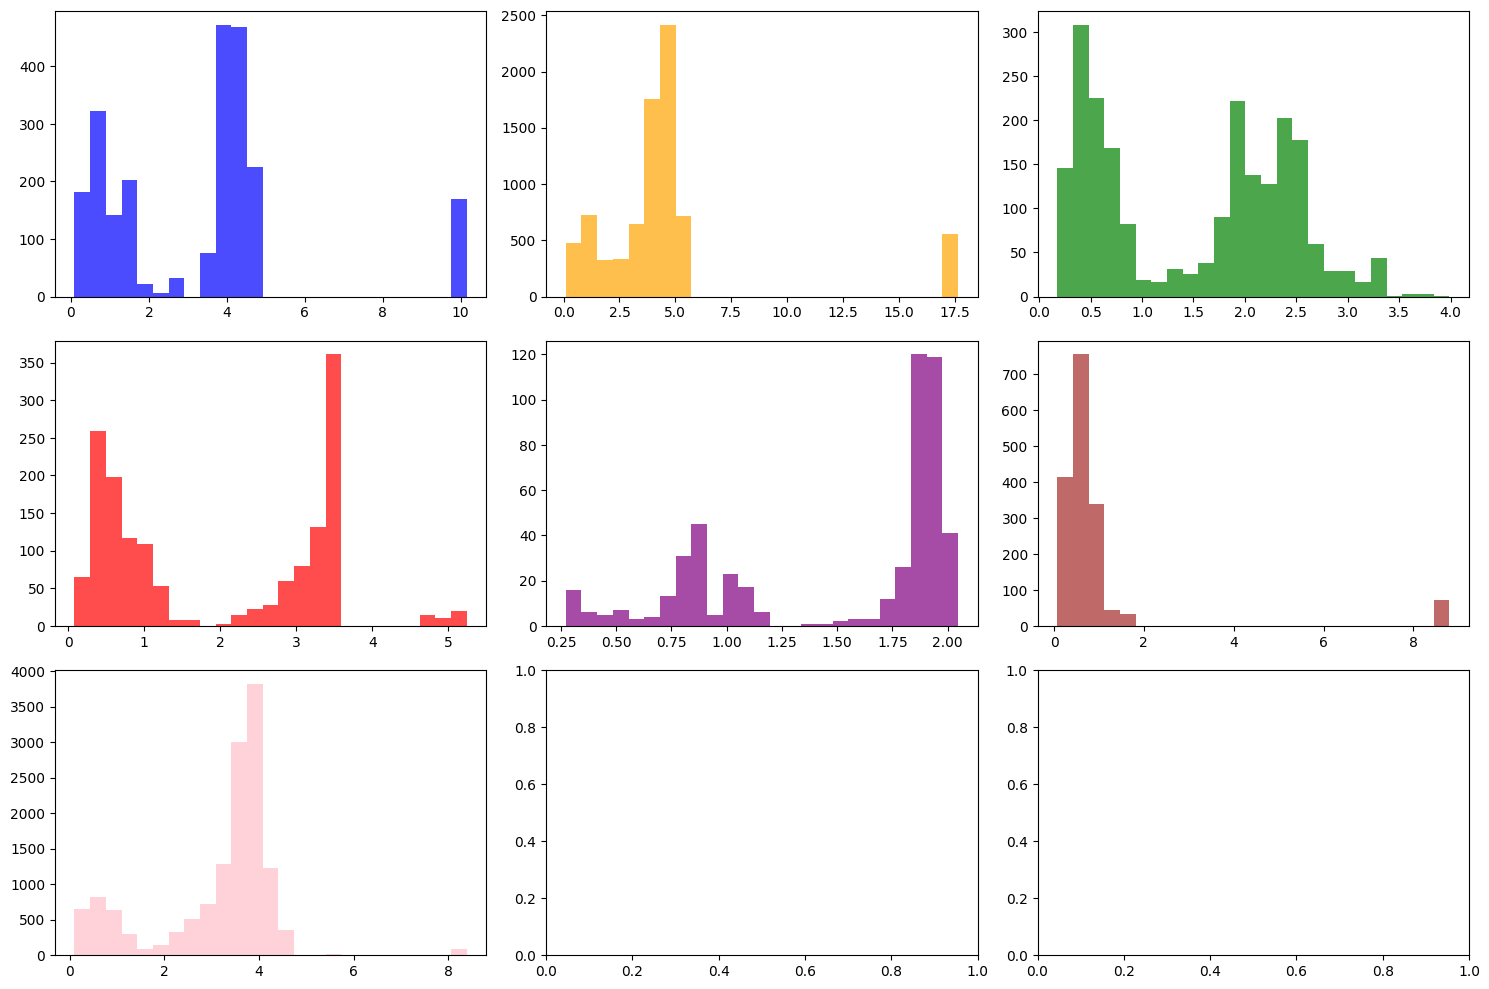

In [152]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Flatten the axs array to simplify indexing
axs = axs.flatten()

# Plot histograms
axs[0].hist(bertopic.sbert_distances[np.where(np.array(bertopic.sbert_clusters)==0)[0]], bins=25, color='blue', alpha=0.7)
axs[1].hist(bertopic.sbert_distances[np.where(np.array(bertopic.sbert_clusters)==1)[0]], bins=25, color='orange', alpha=0.7)
axs[2].hist(bertopic.sbert_distances[np.where(np.array(bertopic.sbert_clusters)==2)[0]], bins=25, color='green', alpha=0.7)
axs[3].hist(bertopic.sbert_distances[np.where(np.array(bertopic.sbert_clusters)==3)[0]], bins=25, color='red', alpha=0.7)
axs[4].hist(bertopic.sbert_distances[np.where(np.array(bertopic.sbert_clusters)==4)[0]], bins=25, color='purple', alpha=0.7)
axs[5].hist(bertopic.sbert_distances[np.where(np.array(bertopic.sbert_clusters)==5)[0]], bins=25, color='brown', alpha=0.7)
axs[6].hist(bertopic.sbert_distances[np.where(np.array(bertopic.sbert_clusters)==6)[0]], bins=25, color='pink', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [168]:
min_threshold = 4
max_threshold = 5
upper_idx=bertopic.get_sbert_norm_outliers(min_threshold)
lower_idx=bertopic.get_sbert_norm_outliers(max_threshold)
for i in range(len(setopics)):
    print(setopics[i])
    n=len(list(set(upper_idx[i])-set(lower_idx[i])))
    print('total', n/np.unique(bertopic.sbert_clusters, return_counts=True)[1][i])
    if n>0:
        print('example:',data1['text'][list(set(upper_idx[i])-set(lower_idx[i]))[random.randint(n)]])
    print('')

Virus Origin and bioweapon theory
total 0.3445450625269513
example: The stones at Stonehenge are moved every year to accommodate for daylight saving time.

Virus contraction (who contracts the virus) and transmission (what transmits the virus)
total 0.4125346086081047
example: Billboard says 'thank a taxpayer not Kejriwal'

Incidence, Mortality and 'Casedemic'
total 0.0

Prevention (Face Mask, Vitamin D, etc.)
total 0.014093529788597053
example: Pune Railway belongs to Adani

Treatment (Ivermectim, chloroquine and hydroxychloroquine, etc)
total 0.0

Vaccines
total 0.0

COVID-19 Denialism
total 0.14915666094911378
example: The high court normally has a complement of nine justices but with Associate Justice Anthony Kennedy’s retirement July 31, which cleared the way for Kavanaugh’s nomination, there have only been only eight justices in place.



In [170]:
min_threshold = 1
max_threshold = 1.2
upper_idx=bertopic.get_sbert_norm_outliers(min_threshold)
lower_idx=bertopic.get_sbert_norm_outliers(max_threshold)
for i in range(len(setopics)):
    print(setopics[i])
    n=len(list(set(upper_idx[i])-set(lower_idx[i])))
    print('total', n/np.unique(bertopic.sbert_clusters, return_counts=True)[1][i])
    if n>0:
        print('example:',data1['text'][list(set(upper_idx[i])-set(lower_idx[i]))[random.randint(n)]])
    print('')

Virus Origin and bioweapon theory
total 0.02457956015523933
example: China owns the animation studio DreamWorks.

Virus contraction (who contracts the virus) and transmission (what transmits the virus)
total 0.022401208155046565
example: Audio clip on COVID relates to Dr. Trehan of Medanta

Incidence, Mortality and 'Casedemic'
total 0.009972801450589302
example: The review for this “doctor” is very consistent: Zero bedside manor. Rude. condescending. Not helpful at all. May have vast knowledge but no clue how to speak to patients. Money grabbing.Running extra tests for no reason. Daddy and mommy started clinic so she has place to “work”

Prevention (Face Mask, Vitamin D, etc.)
total 0.03971812940422806
example: Casein is the most relevant chemical carcinogen ever identified

Treatment (Ivermectim, chloroquine and hydroxychloroquine, etc)
total 0.08447937131630648
example: As of April 2021, U.S. COVID-19 vaccine recipients were obliged to wait before donating blood.

Vaccines
total 0.05

In [171]:
min_threshold = 0.5
max_threshold = 0.75
upper_idx=bertopic.get_sbert_norm_outliers(min_threshold)
lower_idx=bertopic.get_sbert_norm_outliers(max_threshold)
for i in range(len(setopics)):
    print(setopics[i])
    n=len(list(set(upper_idx[i])-set(lower_idx[i])))
    print('total', n/np.unique(bertopic.sbert_clusters, return_counts=True)[1][i])
    if n>0:
        print('example:',data1['text'][list(set(upper_idx[i])-set(lower_idx[i]))[random.randint(n)]])
    print('')

Virus Origin and bioweapon theory
total 0.08408796895213454
example: I call it: ""Chinese Wuhan China CCP Coronavirus China Bioweapon from Wuhan and Covered Up by China Until Chinese Government Shipped Whuan China Coronavirus on Planes Around the World so China Wasn't at a Disadvantage China Virus""

Virus contraction (who contracts the virus) and transmission (what transmits the virus)
total 0.027938585451799648
example: purportedly shows CNN airing a chyron that reads, “Hospitals On Lockdown As First COVID Vaccine Patients Start Eating Other Patients.”

Incidence, Mortality and 'Casedemic'
total 0.14641885766092474
example: Republicans claim to be #ProLife but kill cops. Republicans claim to be #ProLife but are OK with 430,000 COVID deaths. Republicans claim to be #ProLife but don't care if Americans go hungry or homeless. Republicans are not #ProLife in any way. They just don't care.

Prevention (Face Mask, Vitamin D, etc.)
total 0.14541960281870595
example: Holding your breath for 

# dataset 2

In [4]:
data2 = preprocess_for_bow('claimreviews.csv', preprocessing=False)
bertopic2=BERTopicWrapper(data2['text'], data2['ids'], custom_vectorizer=True, representation_model=chained_representation)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [25]:
bertopic2.set_topics(setopics, top_n=50, min_sim=0.35)

In [26]:
bertopic2.sbert_cluster_set_topics()

In [27]:
print('this print displays the count of docs associated with the topic labels set')
print('')
for i in range(len(setopics)):
    print('topic:', setopics[i], 'yields ', len(bertopic2.topics_set_embeddings[i]['topic_idxs']),
            'distributed over', len(bertopic2.topics_set_embeddings[i]['topic_labels']),'original bertopics')

this print displays the count of docs associated with the topic labels set

topic: Virus Origin and bioweapon theory yields  156 distributed over 10 original bertopics
topic: Virus contraction (who contracts the virus) and transmission (what transmits the virus) yields  98 distributed over 5 original bertopics
topic: Incidence, Mortality and 'Casedemic' yields  803 distributed over 42 original bertopics
topic: Prevention (Face Mask, Vitamin D, etc.) yields  451 distributed over 5 original bertopics
topic: Treatment (Ivermectim, chloroquine and hydroxychloroquine, etc) yields  102 distributed over 4 original bertopics
topic: Vaccines yields  802 distributed over 45 original bertopics
topic: COVID-19 Denialism yields  1129 distributed over 50 original bertopics


In [28]:
np.unique(bertopic2.sbert_clusters, return_counts=True)
for i in range(len(setopics)):
    print(bertopic2.topics_set_embeddings[i]['topic_title'],'->',np.unique(bertopic2.sbert_clusters, return_counts=True)[1][i])

Virus Origin and bioweapon theory -> 253
Virus contraction (who contracts the virus) and transmission (what transmits the virus) -> 317
Incidence, Mortality and 'Casedemic' -> 7937
Prevention (Face Mask, Vitamin D, etc.) -> 7103
Treatment (Ivermectim, chloroquine and hydroxychloroquine, etc) -> 636
Vaccines -> 1539
COVID-19 Denialism -> 210


In [84]:
print('examples clusteres')
np.unique(bertopic2.sbert_clusters, return_counts=True)
for i in range(len(setopics)):
    print(bertopic2.topics_set_embeddings[i]['topic_title'],'->',data2['text'][bertopic2.topics_set_embeddings[i]['topic_idxs'][5]])

examples clusteres
Virus Origin and bioweapon theory -> We’ve been asked to look into claims that the Covid-19 virus hasn’t been isolated, doesn’t fulfil “Koch’s postulates”, and that this means PCR diagnosis tests aren’t working.Honesty in public debate mattersYou can help us take action – and get our regular free emailI’m inIsolating a virusFirstly it is incorrect to say that the virus that causes Covid-19 has not been isolated.Isolating a virus means taking a pure sample of a virus from an infected being so it can be studied. There are numerous reports of the virus being isolated by teams around the world.“SARS-CoV2 has been sampled millions of times over from infected people, including those originally found to be infected in China,” Dr Stephen Griffin, a virologist and Associate Professor at Leeds Institute of Medical Research, told Full Fact.Koch’s postulatesIt’s also incorrect to say that the virus that causes Covid-19 would need to meet Koch’s postulates, primarily because Koch

## using examples instead of labels

In [92]:
topic_examples2=[data2['text'][bertopic2.topics_set_embeddings[0]['topic_idxs'][2]], 
          data2['text'][bertopic2.topics_set_embeddings[-1]['topic_idxs'][1]], 
        data2['text'][bertopic2.topics_set_embeddings[2]['topic_idxs'][1]], 
        data2['text'][bertopic2.topics_set_embeddings[3]['topic_idxs'][0]], 
        data2['text'][bertopic2.topics_set_embeddings[4]['topic_idxs'][0]], 
        data2['text'][bertopic2.topics_set_embeddings[5]['topic_idxs'][0]], 
        data2['text'][bertopic2.topics_set_embeddings[-1]['topic_idxs'][5]]]

examples chosen

In [110]:
for example in topic_examples2:
    print(example)

Did George Soros, Bill Gates and the Rockefeller family create the COVID-19 virus, as a three-judge Peruvian court declared? No, that's not true: Although the exact location and origin of the virus has not been definitively identified, many virologists and other scientists studying the issue believe it likely spread from bats to humans in a live market in Wuhan, China. The judges in Peru appear to have used one of the many baseless conspiracy theories surrounding the origin of COVID-19 as a convenient excuse for not having a ruling on time in an unrelated court case.The story appeared in an article published by the 20minutos newspaper in Spain on January 11, 2021, titled, ""Un tribunal peruano acusa a Bill Gates, Soros y Rockefeller de crear la COVID-19"" (In English: ""A Peruvian court accuses Bill Gates, Soros and Rockefeller of creating COVID-19"") (archived here) which opened:Un tribunal de Perú afirmó, en una resolución basada en teorías conspirativas, que la COVID-19 fue una inve

In [95]:
bertopic2.set_topics(topic_examples2, top_n=50, min_sim=0.55)
bertopic2.sbert_cluster_set_topics()

In [102]:
print('this print displays the count of docs associated with the topic labels set')
print('')
for i in range(len(setopics)):
    print('topic:', i, 'yields ', len(bertopic2.topics_set_embeddings[i]['topic_idxs']),
            'distributed over', len(bertopic2.topics_set_embeddings[i]['topic_labels']),'original bertopics')

this print displays the count of docs associated with the topic labels set

topic: 0 yields  567 distributed over 15 original bertopics
topic: 1 yields  7555 distributed over 50 original bertopics
topic: 2 yields  7096 distributed over 31 original bertopics
topic: 3 yields  472 distributed over 17 original bertopics
topic: 4 yields  346 distributed over 14 original bertopics
topic: 5 yields  594 distributed over 31 original bertopics
topic: 6 yields  7065 distributed over 21 original bertopics


In [103]:
print('examples clusteres')
np.unique(bertopic2.sbert_clusters, return_counts=True)
for i in range(len(setopics)):
    print(setopics[i],'->',data2['text'][bertopic2.topics_set_embeddings[i]['topic_idxs'][5]])

examples clusteres
Virus Origin and bioweapon theory -> We’ve been asked to look into claims that the Covid-19 virus hasn’t been isolated, doesn’t fulfil “Koch’s postulates”, and that this means PCR diagnosis tests aren’t working.Honesty in public debate mattersYou can help us take action – and get our regular free emailI’m inIsolating a virusFirstly it is incorrect to say that the virus that causes Covid-19 has not been isolated.Isolating a virus means taking a pure sample of a virus from an infected being so it can be studied. There are numerous reports of the virus being isolated by teams around the world.“SARS-CoV2 has been sampled millions of times over from infected people, including those originally found to be infected in China,” Dr Stephen Griffin, a virologist and Associate Professor at Leeds Institute of Medical Research, told Full Fact.Koch’s postulatesIt’s also incorrect to say that the virus that causes Covid-19 would need to meet Koch’s postulates, primarily because Koch

In [104]:
print('reclustering')
np.unique(bertopic2.sbert_clusters, return_counts=True)
for i in range(len(setopics)):
    print(setopics[i],'->',np.unique(bertopic2.sbert_clusters, return_counts=True)[1][i])

reclustering
Virus Origin and bioweapon theory -> 6824
Virus contraction (who contracts the virus) and transmission (what transmits the virus) -> 3819
Incidence, Mortality and 'Casedemic' -> 728
Prevention (Face Mask, Vitamin D, etc.) -> 150
Treatment (Ivermectim, chloroquine and hydroxychloroquine, etc) -> 3194
Vaccines -> 952
COVID-19 Denialism -> 2328


## z-test: exploration of outliers

In [105]:
# 25% of distribution with smallest distance to centroids
top_to_remove = 0.75
bottom_to_remove = 1
outliersMinP=bertopic2.get_sbert_z_outliers(norm.ppf(bottom_to_remove/2))
outliersMaxP=bertopic2.get_sbert_z_outliers(norm.ppf(top_to_remove/2))
for i in range(len(setopics)):
    print(setopics[i])
    n=len(list(set(outliersMinP[i])-set(outliersMaxP[i])))
    print('total', n)
    if n>0:
        print('example:',data2['text'][list(set(outliersMinP[i])-set(outliersMaxP[i]))[random.randint(n)]])
    print('')

Virus Origin and bioweapon theory
total 3217
example: Did LeBron James and Anthony Davis, the Los Angeles Lakers' leading scorers this season, wear lace collars to honor the life of Supreme Court Justice Ruth Bader Ginsburg after her death? No, that's not true: This is a satirical claim published by a known satire website. Neither James, Davis, nor any other NBA players have worn lace collars in the couple games that have happened since her death.The claim originated from an article published by ""The Babylon Bee"" on September 22, 2020, titled ""NBA Players Wear Special Lace Collars To Honor Ruth Bader Ginsburg"" (archived here) which opened:LOS ANGELES, CA--NBA players are honoring the life of Ruth Bader Ginsburg this week by wearing pretty lace collars just like Notorious RBG used to wear. In a touching show of respect for the late Justice Ginsburg, and in solidarity with her progressive cause, Lebron James and the LA Lakers took to the court yesterday wearing a stunning variety of 

In [106]:
# from 50% to 75% of the distribution with smallest distance
top_to_remove = 0.25
bottom_to_remove = 0.5
outliersMinP=bertopic2.get_sbert_z_outliers(norm.ppf(bottom_to_remove/2))
outliersMaxP=bertopic2.get_sbert_z_outliers(norm.ppf(top_to_remove/2))
for i in range(len(setopics)):
    print(setopics[i])
    n=len(list(set(outliersMinP[i])-set(outliersMaxP[i])))
    print('total', n)
    if n>0:
        print('example:',data2['text'][list(set(outliersMinP[i])-set(outliersMaxP[i]))[random.randint(n)]])
    print('')

Virus Origin and bioweapon theory
total 741
example: FACT CHECK: Viral Image Claims To Show Nancy Pelosi Violating COVID-19 Safety Guidelines For Social GatheringsAn image shared on Facebook claims to show House Speaker Nancy Pelosi violating coronavirus safety guidelines by attending a party and not wearing a mask.Verdict: FalseThe image was taken in January 2020, over a week before the U.S. confirmed its first COVID-19 case.Fact Check:Under phase two coronavirus restrictions put in place by D.C. Mayor Muriel Bowser, indoor gatherings are currently limited to 10 people, and restaurants are limited to operating at 25 percent capacity indoors. Masks must be worn inside public establishments except while eating or drinking, according to the guidelines.A post on Facebook shares an image of Pelosi gathered around several people. No one appears to be wearing a mask or practicing social distancing. The photo’s caption reads, “Ladies and Gentlemen here’s your speaker of the house enjoying a p

In [107]:
# from 75% to 95% of the distribution with smallest distance - strongest outliers
top_to_remove = 0.05
bottom_to_remove = 0.25
outliersMinP=bertopic2.get_sbert_z_outliers(norm.ppf(bottom_to_remove/2))
outliersMaxP=bertopic2.get_sbert_z_outliers(norm.ppf(top_to_remove/2))
for i in range(len(setopics)):
    print(setopics[i])
    n=len(list(set(outliersMinP[i])-set(outliersMaxP[i])))
    print('total', n)
    if n>0:
        print('example:',data2['text'][list(set(outliersMinP[i])-set(outliersMaxP[i]))[random.randint(n)]])
    print('')

Virus Origin and bioweapon theory
total 514
example: The spread of novel coronavirus, which was first declared as a pandemic by the World Health Organisation (WHO) on 11 March has since then become a target of misinformation and conspiracy theories alike.In one such instance, several users on social media are claiming that the 16th century French astrologer Nostradamus predicted the virus in his book ‘Les Propheties’ (The Prophecies). However, after proper checks and verification, we have found that there is no truth to these claims.THE CLAIMAccording to the claim being circulated on the internet, French philosopher Nostradamus in his book, ‘Les Propheties’ (The Prophecies) wrote: “There will be a twin year (2020) from which will arise a queen (corona) who will come from the east (China) and will spread a plague (virus)in the darkness of night, on a country with 7 hills (Italy) and will transform the twilight of men into dust (death), to destroy, and ruin the world. (sic)”WHAT WE FOUND

## exploration via distance measure

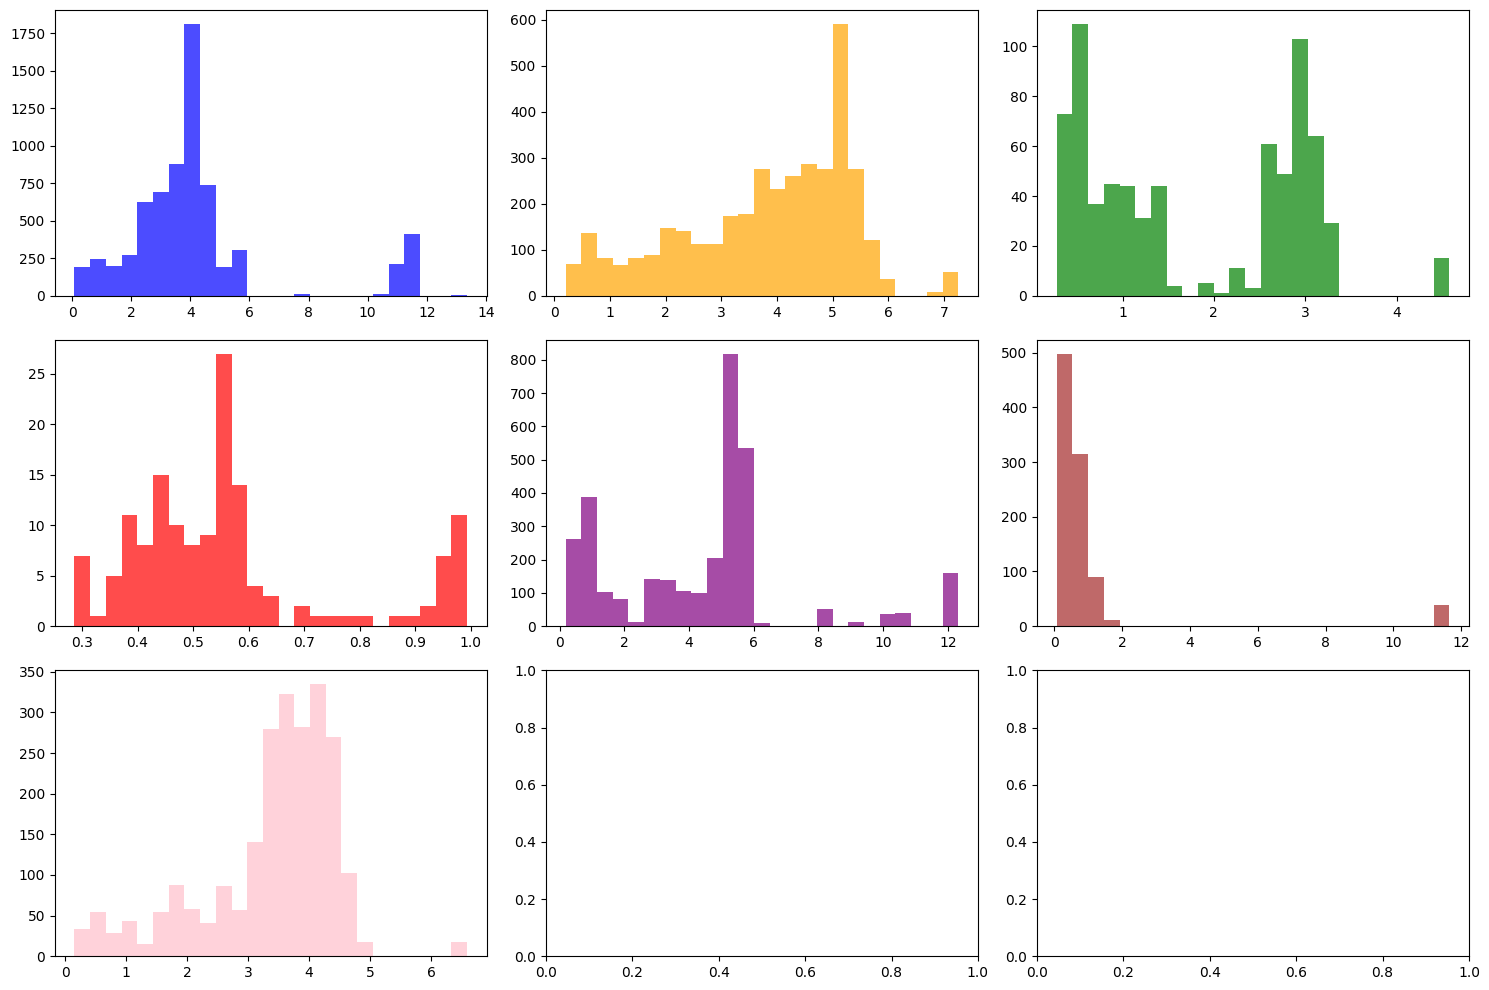

In [133]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Flatten the axs array to simplify indexing
axs = axs.flatten()

# Plot histograms
axs[0].hist(bertopic2.sbert_distances[np.where(np.array(bertopic2.sbert_clusters)==0)[0]], bins=25, color='blue', alpha=0.7)
axs[1].hist(bertopic2.sbert_distances[np.where(np.array(bertopic2.sbert_clusters)==1)[0]], bins=25, color='orange', alpha=0.7)
axs[2].hist(bertopic2.sbert_distances[np.where(np.array(bertopic2.sbert_clusters)==2)[0]], bins=25, color='green', alpha=0.7)
axs[3].hist(bertopic2.sbert_distances[np.where(np.array(bertopic2.sbert_clusters)==3)[0]], bins=25, color='red', alpha=0.7)
axs[4].hist(bertopic2.sbert_distances[np.where(np.array(bertopic2.sbert_clusters)==4)[0]], bins=25, color='purple', alpha=0.7)
axs[5].hist(bertopic2.sbert_distances[np.where(np.array(bertopic2.sbert_clusters)==5)[0]], bins=25, color='brown', alpha=0.7)
axs[6].hist(bertopic2.sbert_distances[np.where(np.array(bertopic2.sbert_clusters)==6)[0]], bins=25, color='pink', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [172]:
min_threshold = 6
max_threshold = 7
upper_idx=bertopic2.get_sbert_norm_outliers(min_threshold)
lower_idx=bertopic2.get_sbert_norm_outliers(max_threshold)
for i in range(len(setopics)):
    print(setopics[i])
    n=len(list(set(upper_idx[i])-set(lower_idx[i])))
    print('total', n/np.unique(bertopic2.sbert_clusters, return_counts=True)[1][i])
    if n>0:
        print('example:',data2['text'][list(set(upper_idx[i])-set(lower_idx[i]))[random.randint(n)]])
    print('')

Virus Origin and bioweapon theory
total 0.0

Virus contraction (who contracts the virus) and transmission (what transmits the virus)
total 0.004451427075150563
example: This article is more than 3 years old- Kenyatta stressed the importance of micro, small and medium enterprises in the Kenyan economy when addressing the nation in early 2020.- In researching the president’s claims, it became clear that data on the number of MSMEs in Kenya, how many jobs they create and how much they contribute to GDP has been inconsistently surveyed and is not up-to-date.- While available data supports the importance of MSMEs in the Kenyan economy, a lack of cooperation between state agencies makes statistics for the sector difficult to calculate.Micro, small and medium enterprises (MSMEs), he said, were a “powerful engine” and the “lifeblood” of the economy.Kenyatta then made three claims about the number of these businesses, how many jobs they create and their contribution to the gross domestic produc

In [173]:
min_threshold = 2
max_threshold = 2.2
upper_idx=bertopic2.get_sbert_norm_outliers(min_threshold)
lower_idx=bertopic2.get_sbert_norm_outliers(max_threshold)
for i in range(len(setopics)):
    print(setopics[i])
    n=len(list(set(upper_idx[i])-set(lower_idx[i])))
    print('total', n/np.unique(bertopic2.sbert_clusters, return_counts=True)[1][i])
    if n>0:
        print('example:',data2['text'][list(set(upper_idx[i])-set(lower_idx[i]))[random.randint(n)]])
    print('')

Virus Origin and bioweapon theory
total 0.022274325908558032
example: On Oct. 14, 2020, a photograph supposedly showing three U.S. Democratic lawmakers in close proximity to one another while not wearing face masks was circulated on social media along with the false insinuation that it was taken during Supreme Court nominee Amy Coney Barrett's confirmation hearing. The misleading image reached a larger audience when it was amplified by Republican Sen. John Cornyn of Texas:This is a genuine image of three Democratic lawmakers not wearing masks. However, this photograph was taken long before the start of the COVID-19 pandemic when wearing masks became widely recommended in the United States.This photograph was taken on Sept. 4, 2018, by Associated Press photographer J. Scott Applewhite. It shows Sens. Sheldon Whitehouse, Cory Booker, and Richard Blumenthal, all Democrats, during the confirmation hearing of Supreme Court nominee Brett Kavanaugh.The image was originally posted by The Assoc

In [174]:
min_threshold = 1
max_threshold = 1.2
upper_idx=bertopic2.get_sbert_norm_outliers(min_threshold)
lower_idx=bertopic2.get_sbert_norm_outliers(max_threshold)
for i in range(len(setopics)):
    print(setopics[i])
    n=len(list(set(upper_idx[i])-set(lower_idx[i])))
    print('total', n/np.unique(bertopic2.sbert_clusters, return_counts=True)[1][i])
    if n>0:
        print('example:',data2['text'][list(set(upper_idx[i])-set(lower_idx[i]))[random.randint(n)]])
    print('')

Virus Origin and bioweapon theory
total 0.021981242672919107
example: On March 18, 2021, a video circulated on social media that supposedly showed U.S. President Joe Biden referring to Vice President Kamala Harris as ""President Harris.""This is a genuine video.This footage comes from remarks Biden delivered on March 18, 2021, concerning the state of the COVID-19 pandemic and the vaccine rollout. Fox News reported:The United States is on track to hit President Joe Biden’s goal of vaccinating 100 million Americans against coronavirus on Friday, just 58 days after his inauguration. In an update provided Thursday, Biden said that while the number is encouraging, the country still has much work to do before it can declare victory against the virus.""Tomorrow, we will hit 100 million doses our administration has administered,"" Biden said. ""I’ve always said that’s just the floor, we will not stop until we beat this pandemic. Next week I’ll announce our next goal to put shots in arms.""Duri